In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [2]:
df_tr = pd.read_csv('train_reg.csv')
df_tes = pd.read_csv('test_reg.csv')

In [3]:
display(df_tr.head(5))
display(df_tes.head(5))


,x,y
0,0.415709,2.267527
1,2.078132,5.761260
2,6.152402,17.237352
3,7.064143,18.693992
4,8.140977,23.252819


,x
0,5.913738
1,2.657985
2,-0.666239
3,9.891288
4,7.224223


In [4]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       100 non-null    float64
 1   y       100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


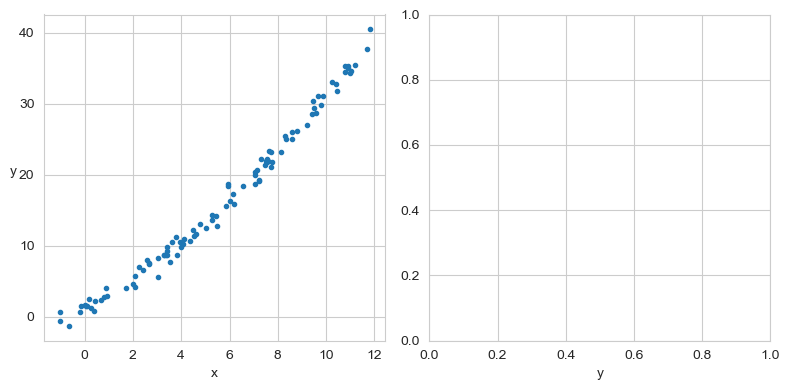

In [10]:
_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(df_tr['x'], df_tr['y'], 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
# ax[0].plot(df_tr['x'], df_tr['y'], 'k')
#az.plot_kde(df_tr['y'], ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [11]:
x = df_tr['x']
y = df_tr['y']
x = (x - x.mean())/x.std()
# y = (y - y.mean())/y.std()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,16.194,0.171,15.857,16.510,0.002,0.001,12237.0,6321.0,1.0
β,10.871,0.170,10.564,11.203,0.002,0.001,11243.0,6048.0,1.0
ε,1.697,0.126,1.461,1.928,0.001,0.001,10266.0,6383.0,1.0


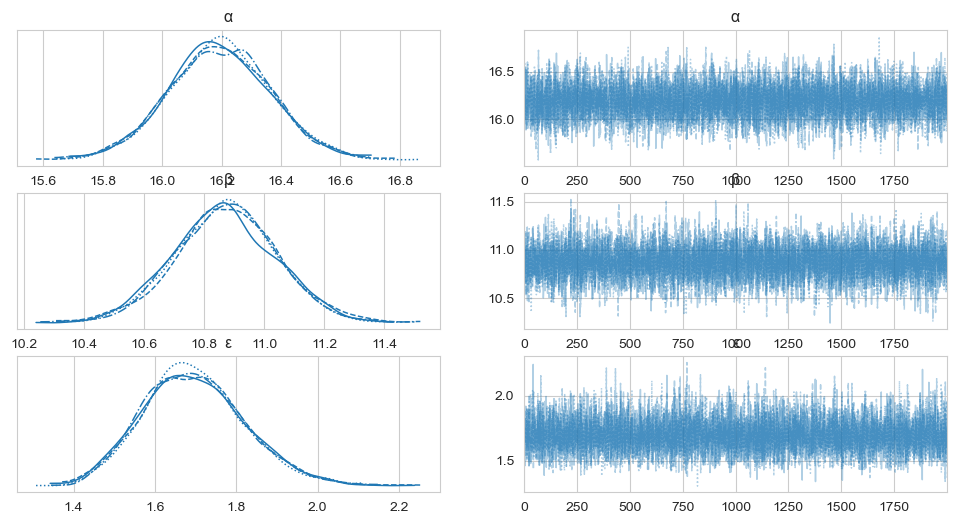

In [12]:
np.random.seed(42)
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=8)
    β = pm.Normal('β', mu=0, sigma=3)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

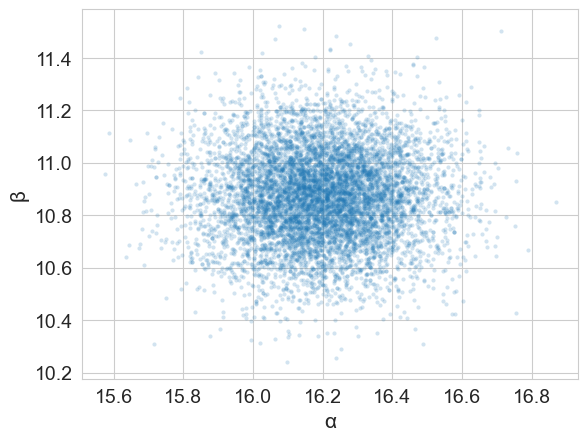

In [13]:
az.plot_pair(trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.2}); #корреляции нет

In [14]:
posterior_g = az.extract(trace_g)


alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(x, posterior_g['α'][draws].values +
                 posterior_g['β'][draws].values * x[:,None], c='gray', alpha=0.1)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

всего трасс :  8000


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

Задание 1: парамерты alpha: 16.19, beta:10.88

## Задание 2 **Предсказание**

In [15]:
ppc = pm.sample_posterior_predictive(trace_g, model=model_g)

Sampling: [y_pred]


In [16]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

In [17]:
alpha = trace_g.posterior['α'].mean(("chain", "draw")).values
beta = trace_g.posterior["β"].mean(("chain", "draw")).values


y_pred = alpha+beta*(df_tes['x'])

In [20]:
y_pred

0      80.483086
1      45.089074
2       8.950702
3     123.723913
4      94.729660
         ...    
95    116.139179
96    131.273781
97     36.247698
98     22.041231
99     85.839205
Name: x, Length: 100, dtype: float64

In [22]:
from sklearn.metrics import mean_squared_error
y_true = pd.read_csv('test_Y_true_reg.csv')
mean_squared_error(y_true, y_pred)

4149.3158837991805